# Ground Station to Ground Station Routing Test

This notebook tests routing **directly between two ground stations** to verify that:
- Model only learns routing between GS (not terminal-to-GS selection)
- RL model can find optimal paths between GS through satellites
- Performance comparison with Dijkstra algorithm

**Key Difference**: This test bypasses terminal selection and tests pure GS-to-GS routing.


## 1. Setup & Configuration


In [1]:
# Setup paths and imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import warnings
import time
import torch
warnings.filterwarnings('ignore')

# Add backend to path
backend_path = os.path.abspath('..')
if backend_path not in sys.path:
    sys.path.insert(0, backend_path)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✓ Setup complete")


✓ Setup complete


In [2]:
# Import project modules
from config import Config
from models.database import Database
from agent.dueling_dqn import DuelingDQNAgent
from environment.routing_env import RoutingEnvironment
from environment.state_builder import RoutingStateBuilder
from api.routing_bp import calculate_path_dijkstra, calculate_distance

# Initialize
config = Config.get_yaml_config()
db = Database()
db.connect()

print("✓ Modules loaded")
print(f"✓ Database connected: {db.db.name}")
print(f"✓ Config loaded")


✓ Modules loaded
✓ Database connected: aiprancs
✓ Config loaded


## 2. Load Network Data


In [3]:
# Load nodes and terminals from database
nodes_collection = db.get_collection('nodes')
terminals_collection = db.get_collection('terminals')

# Get all operational nodes
nodes = list(nodes_collection.find({'isOperational': True}, {'_id': 0}))

# Get all terminals (for creating dummy terminals if needed)
terminals = list(terminals_collection.find({}, {'_id': 0}))

# Filter ground stations
ground_stations = [n for n in nodes if n.get('nodeType') == 'GROUND_STATION']

print(f"✓ Loaded {len(nodes)} operational nodes")
print(f"✓ Loaded {len(ground_stations)} ground stations")
print(f"✓ Loaded {len(terminals)} terminals")

if len(ground_stations) < 2:
    raise ValueError("Need at least 2 ground stations for testing")


✓ Loaded 53 operational nodes
✓ Loaded 20 ground stations
✓ Loaded 30 terminals


## 3. Load Best RL Model


In [4]:
# Load checkpoint to get correct dimensions
best_model_path_str = config.get('rl_agent', {}).get('best_model_path', './models/best_models')
if not os.path.isabs(best_model_path_str):
    backend_root = Path(os.path.abspath('..'))
    best_model_dir = backend_root / best_model_path_str.lstrip('./')
else:
    best_model_dir = Path(best_model_path_str)
best_model_path = best_model_dir / 'best_model.pt'

# Load checkpoint to get state_dim and action_dim
state_dim = None
action_dim = None

if best_model_path.exists():
    try:
        checkpoint = torch.load(str(best_model_path), map_location='cpu', weights_only=False)
        if 'state_dim' in checkpoint:
            state_dim = checkpoint['state_dim']
        if 'action_dim' in checkpoint:
            action_dim = checkpoint['action_dim']
        
        # Infer from state_dict if not in checkpoint
        if state_dim is None and 'q_network_state_dict' in checkpoint:
            for key in checkpoint['q_network_state_dict'].keys():
                if 'input_norm.weight' in key:
                    state_dim = checkpoint['q_network_state_dict'][key].shape[0]
                    break
        
        if action_dim is None and 'q_network_state_dict' in checkpoint:
            for key in checkpoint['q_network_state_dict'].keys():
                if 'advantage_stream.6.weight' in key:
                    action_dim = checkpoint['q_network_state_dict'][key].shape[0]
                    break
        
        logger.info(f"Loaded dimensions from checkpoint: state_dim={state_dim}, action_dim={action_dim}")
    except Exception as e:
        logger.warning(f"Could not read checkpoint dimensions: {e}")

# If checkpoint dimensions not available, use config
if state_dim is None or action_dim is None:
    state_builder_temp = RoutingStateBuilder(config)
    env_temp = RoutingEnvironment(nodes=nodes, terminals=terminals[:2] if terminals else [], config=config, max_steps=15)
    state_dim = state_builder_temp.state_dimension
    action_dim = env_temp.action_space.n
    logger.info(f"Using dimensions from config: state_dim={state_dim}, action_dim={action_dim}")

# Create agent
agent = DuelingDQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    config=config
)

# Load model
if best_model_path.exists():
    try:
        agent.load(str(best_model_path))
        agent.eval()
        logger.info(f"✓ Loaded trained model from {best_model_path}")
        model_loaded = True
    except Exception as e:
        logger.warning(f"Could not load model: {e}. Using untrained model.")
        agent.eval()
        model_loaded = False
else:
    logger.info("No trained model found. Using untrained model for testing.")
    agent.eval()
    model_loaded = False

print(f"\n📊 Model Status:")
print(f"  State dimension: {state_dim}")
print(f"  Action dimension: {action_dim}")
print(f"  Model loaded: {model_loaded}")


INFO:__main__:Loaded dimensions from checkpoint: state_dim=974, action_dim=53
INFO:agent.dueling_dqn:Initializing DuelingDQN Agent on device: cpu
INFO:agent.dueling_dqn:DuelingDQN Agent initialized: state_dim=974, action_dim=53
INFO:agent.dueling_dqn:Agent loaded from /Users/anhnon/AI-PRACNS/Backend/models/best_models/best_model.pt
INFO:__main__:✓ Loaded trained model from /Users/anhnon/AI-PRACNS/Backend/models/best_models/best_model.pt



📊 Model Status:
  State dimension: 974
  Action dimension: 53
  Model loaded: True


## 4. Test Function: GS to GS Routing


## 5. Run Tests


In [5]:
def test_gs_to_gs_routing(
    source_gs: Dict,
    dest_gs: Dict,
    nodes: List[Dict],
    terminals: List[Dict],
    agent: DuelingDQNAgent,
    config: Dict
) -> Dict:
    """
    Test routing directly between two ground stations
    
    Args:
        source_gs: Source ground station node
        dest_gs: Destination ground station node
        nodes: All operational nodes
        terminals: List of terminals (for environment)
        agent: Trained RL agent
        config: Configuration dict
    
    Returns:
        Dict with routing results (RL and Dijkstra)
    """
    # Create dummy terminals at GS positions for environment
    source_terminal = {
        'terminalId': f'DUMMY-SRC-{source_gs["nodeId"]}',
        'position': source_gs.get('position'),
        'terminalName': f'Dummy Source at {source_gs["nodeId"]}'
    }
    
    dest_terminal = {
        'terminalId': f'DUMMY-DEST-{dest_gs["nodeId"]}',
        'position': dest_gs.get('position'),
        'terminalName': f'Dummy Dest at {dest_gs["nodeId"]}'
    }
    
    # Create environment
    env = RoutingEnvironment(
        nodes=nodes,
        terminals=[source_terminal, dest_terminal],
        config=config,
        max_steps=15
    )
    
    # Reset with explicit ground stations
    state, info = env.reset(
        options={
            'source_terminal_id': source_terminal['terminalId'],
            'dest_terminal_id': dest_terminal['terminalId'],
            'source_ground_station': source_gs,  # Explicit GS
            'dest_ground_station': dest_gs        # Explicit GS
        }
    )
    
    # RL Routing
    rl_path = None
    rl_success = False
    rl_error = None
    
    try:
        done = False
        step_count = 0
        max_steps = 10
        
        while not done and step_count < max_steps:
            action = agent.select_action(state, deterministic=True)
            next_state, reward, terminated, truncated, step_info = env.step(action)
            
            done = terminated or truncated
            state = next_state
            step_count += 1
        
        if done and terminated:
            rl_success = True
            rl_path = env.get_path_result()
        else:
            rl_error = "Max steps reached or truncated"
    except Exception as e:
        rl_error = str(e)
        logger.error(f"RL routing error: {rl_error}")
    
    # Dijkstra Routing (for comparison)
    dijkstra_path = None
    dijkstra_success = False
    
    try:
        dijkstra_path = calculate_path_dijkstra(
            source_terminal,
            dest_terminal,
            nodes,
            resource_aware=True
        )
        dijkstra_success = dijkstra_path.get('success', False)
    except Exception as e:
        logger.error(f"Dijkstra routing error: {e}")
    
    # Calculate distance between GS
    gs_distance = calculate_distance(
        source_gs.get('position'),
        dest_gs.get('position')
    ) / 1000.0  # km
    
    return {
        'source_gs_id': source_gs['nodeId'],
        'dest_gs_id': dest_gs['nodeId'],
        'gs_distance_km': gs_distance,
        'rl_success': rl_success,
        'rl_path': rl_path,
        'rl_error': rl_error,
        'rl_hops': len(rl_path['path']) - 1 if rl_path and rl_path.get('path') else 0,
        'rl_distance_km': rl_path.get('totalDistance', 0) if rl_path else 0,
        'rl_latency_ms': rl_path.get('estimatedLatency', 0) if rl_path else 0,
        'dijkstra_success': dijkstra_success,
        'dijkstra_path': dijkstra_path,
        'dijkstra_hops': len(dijkstra_path['path']) - 1 if dijkstra_path and dijkstra_path.get('path') else 0,
        'dijkstra_distance_km': dijkstra_path.get('totalDistance', 0) if dijkstra_path else 0,
        'dijkstra_latency_ms': dijkstra_path.get('estimatedLatency', 0) if dijkstra_path else 0
    }

print("✓ Test function defined")


✓ Test function defined


In [6]:
# Test multiple GS pairs
num_tests = 30
results = []

logger.info("=" * 60)
logger.info(f"Testing GS-to-GS Routing ({num_tests} pairs)")
logger.info("=" * 60)

for i in range(num_tests):
    # Randomly select 2 different ground stations
    if len(ground_stations) < 2:
        break
    
    indices = np.random.choice(len(ground_stations), size=2, replace=False)
    source_gs = ground_stations[indices[0]]
    dest_gs = ground_stations[indices[1]]
    
    logger.info(f"\nTest {i+1}/{num_tests}: {source_gs['nodeId']} → {dest_gs['nodeId']}")
    
    result = test_gs_to_gs_routing(
        source_gs=source_gs,
        dest_gs=dest_gs,
        nodes=nodes,
        terminals=terminals,
        agent=agent,
        config=config
    )
    
    results.append(result)
    
    # Log result
    if result['rl_success']:
        logger.info(f"  ✅ RL: {result['rl_hops']} hops, {result['rl_distance_km']:.1f}km, {result['rl_latency_ms']:.2f}ms")
    else:
        logger.info(f"  ❌ RL: {result['rl_error']}")
    
    if result['dijkstra_success']:
        logger.info(f"  ✅ Dijkstra: {result['dijkstra_hops']} hops, {result['dijkstra_distance_km']:.1f}km, {result['dijkstra_latency_ms']:.2f}ms")

print(f"\n✓ Completed {len(results)} tests")


INFO:__main__:============================================================
INFO:__main__:Testing GS-to-GS Routing (30 pairs)
INFO:__main__:============================================================
INFO:__main__:
Test 1/30: GS-042 → GS-036
INFO:environment.routing_env:Dynamic max_steps: 26 (operational_nodes=53, base=15, estimated_hops=26)
INFO:environment.routing_env:RL starting from explicit source GS: GS-042
INFO:environment.routing_env:RL reached exact destination GS: GS-036
INFO:api.routing_bp:✅ Selected optimal Ground Station GS-042 for terminal DUMMY-SRC-GS-042 (score: 0.879, distance: 0.0km, utilization: 44.0%, battery: 100.0%, packet_loss: 0.01%, connections: 0)
INFO:api.routing_bp:✅ Selected optimal Ground Station GS-036 for terminal DUMMY-DEST-GS-036 (score: 0.723, distance: 0.0km, utilization: 44.0%, battery: 100.0%, packet_loss: 0.01%, connections: 0)
INFO:api.routing_bp:📊 Dijkstra path: 4 hops, 18595.9km, 93.93ms latency
INFO:__main__:  ✅ RL: 3 hops, 9155.8km, 45.54ms
I


✓ Completed 30 tests


## 7. Visualizations


## 6. Analyze Results


## 8. Detailed Path Analysis


In [7]:
# Convert to DataFrame
df = pd.DataFrame(results)

# Calculate statistics
rl_success_rate = df['rl_success'].mean() * 100
dijkstra_success_rate = df['dijkstra_success'].mean() * 100

print("=" * 60)
print("GS-to-GS Routing Test Results")
print("=" * 60)
print(f"\n📊 Success Rates:")
print(f"  RL:       {rl_success_rate:.1f}% ({df['rl_success'].sum()}/{len(df)})")
print(f"  Dijkstra: {dijkstra_success_rate:.1f}% ({df['dijkstra_success'].sum()}/{len(df)})")

# Compare successful paths
successful_rl = df[df['rl_success'] == True]
successful_dijkstra = df[df['dijkstra_success'] == True]
both_successful = df[(df['rl_success'] == True) & (df['dijkstra_success'] == True)]

if len(successful_rl) > 0:
    print(f"\n📈 RL Performance (successful paths):")
    print(f"  Mean hops:      {successful_rl['rl_hops'].mean():.2f}")
    print(f"  Mean distance:  {successful_rl['rl_distance_km'].mean():.2f} km")
    print(f"  Mean latency:   {successful_rl['rl_latency_ms'].mean():.2f} ms")

if len(successful_dijkstra) > 0:
    print(f"\n📈 Dijkstra Performance (successful paths):")
    print(f"  Mean hops:      {successful_dijkstra['dijkstra_hops'].mean():.2f}")
    print(f"  Mean distance:  {successful_dijkstra['dijkstra_distance_km'].mean():.2f} km")
    print(f"  Mean latency:   {successful_dijkstra['dijkstra_latency_ms'].mean():.2f} ms")

if len(both_successful) > 0:
    print(f"\n🔄 Comparison (both successful):")
    rl_better_hops = (both_successful['rl_hops'] < both_successful['dijkstra_hops']).sum()
    dijkstra_better_hops = (both_successful['dijkstra_hops'] < both_successful['rl_hops']).sum()
    equal_hops = (both_successful['rl_hops'] == both_successful['dijkstra_hops']).sum()
    
    rl_better_distance = (both_successful['rl_distance_km'] < both_successful['dijkstra_distance_km']).sum()
    dijkstra_better_distance = (both_successful['dijkstra_distance_km'] < both_successful['rl_distance_km']).sum()
    
    print(f"  Hops: RL better={rl_better_hops}, Dijkstra better={dijkstra_better_hops}, Equal={equal_hops}")
    print(f"  Distance: RL better={rl_better_distance}, Dijkstra better={dijkstra_better_distance}")

# Show some example paths
print(f"\n📋 Example Paths:")
for idx, row in df.head(5).iterrows():
    print(f"\n  {row['source_gs_id']} → {row['dest_gs_id']} ({row['gs_distance_km']:.1f}km direct):")
    if row['rl_success']:
        print(f"    RL:       {row['rl_hops']} hops, {row['rl_distance_km']:.1f}km, {row['rl_latency_ms']:.2f}ms")
    else:
        print(f"    RL:       Failed - {row['rl_error']}")
    if row['dijkstra_success']:
        print(f"    Dijkstra: {row['dijkstra_hops']} hops, {row['dijkstra_distance_km']:.1f}km, {row['dijkstra_latency_ms']:.2f}ms")


GS-to-GS Routing Test Results

📊 Success Rates:
  RL:       100.0% (30/30)
  Dijkstra: 100.0% (30/30)

📈 RL Performance (successful paths):
  Mean hops:      3.10
  Mean distance:  8818.62 km
  Mean latency:   44.92 ms

📈 Dijkstra Performance (successful paths):
  Mean hops:      4.23
  Mean distance:  17733.31 km
  Mean latency:   86.16 ms

🔄 Comparison (both successful):
  Hops: RL better=27, Dijkstra better=0, Equal=3
  Distance: RL better=30, Dijkstra better=0

📋 Example Paths:

  GS-042 → GS-036 (9155.8km direct):
    RL:       3 hops, 9155.8km, 45.54ms
    Dijkstra: 4 hops, 18595.9km, 93.93ms

  GS-039 → GS-050 (9401.9km direct):
    RL:       3 hops, 9401.9km, 46.36ms
    Dijkstra: 4 hops, 19477.6km, 90.47ms

  GS-044 → GS-036 (13418.5km direct):
    RL:       4 hops, 15236.8km, 70.82ms
    Dijkstra: 4 hops, 21383.7km, 95.43ms

  GS-044 → GS-036 (13418.5km direct):
    RL:       4 hops, 15236.8km, 70.82ms
    Dijkstra: 4 hops, 21383.7km, 95.43ms

  GS-039 → GS-041 (2486.2km dire

## 7. Visualizations


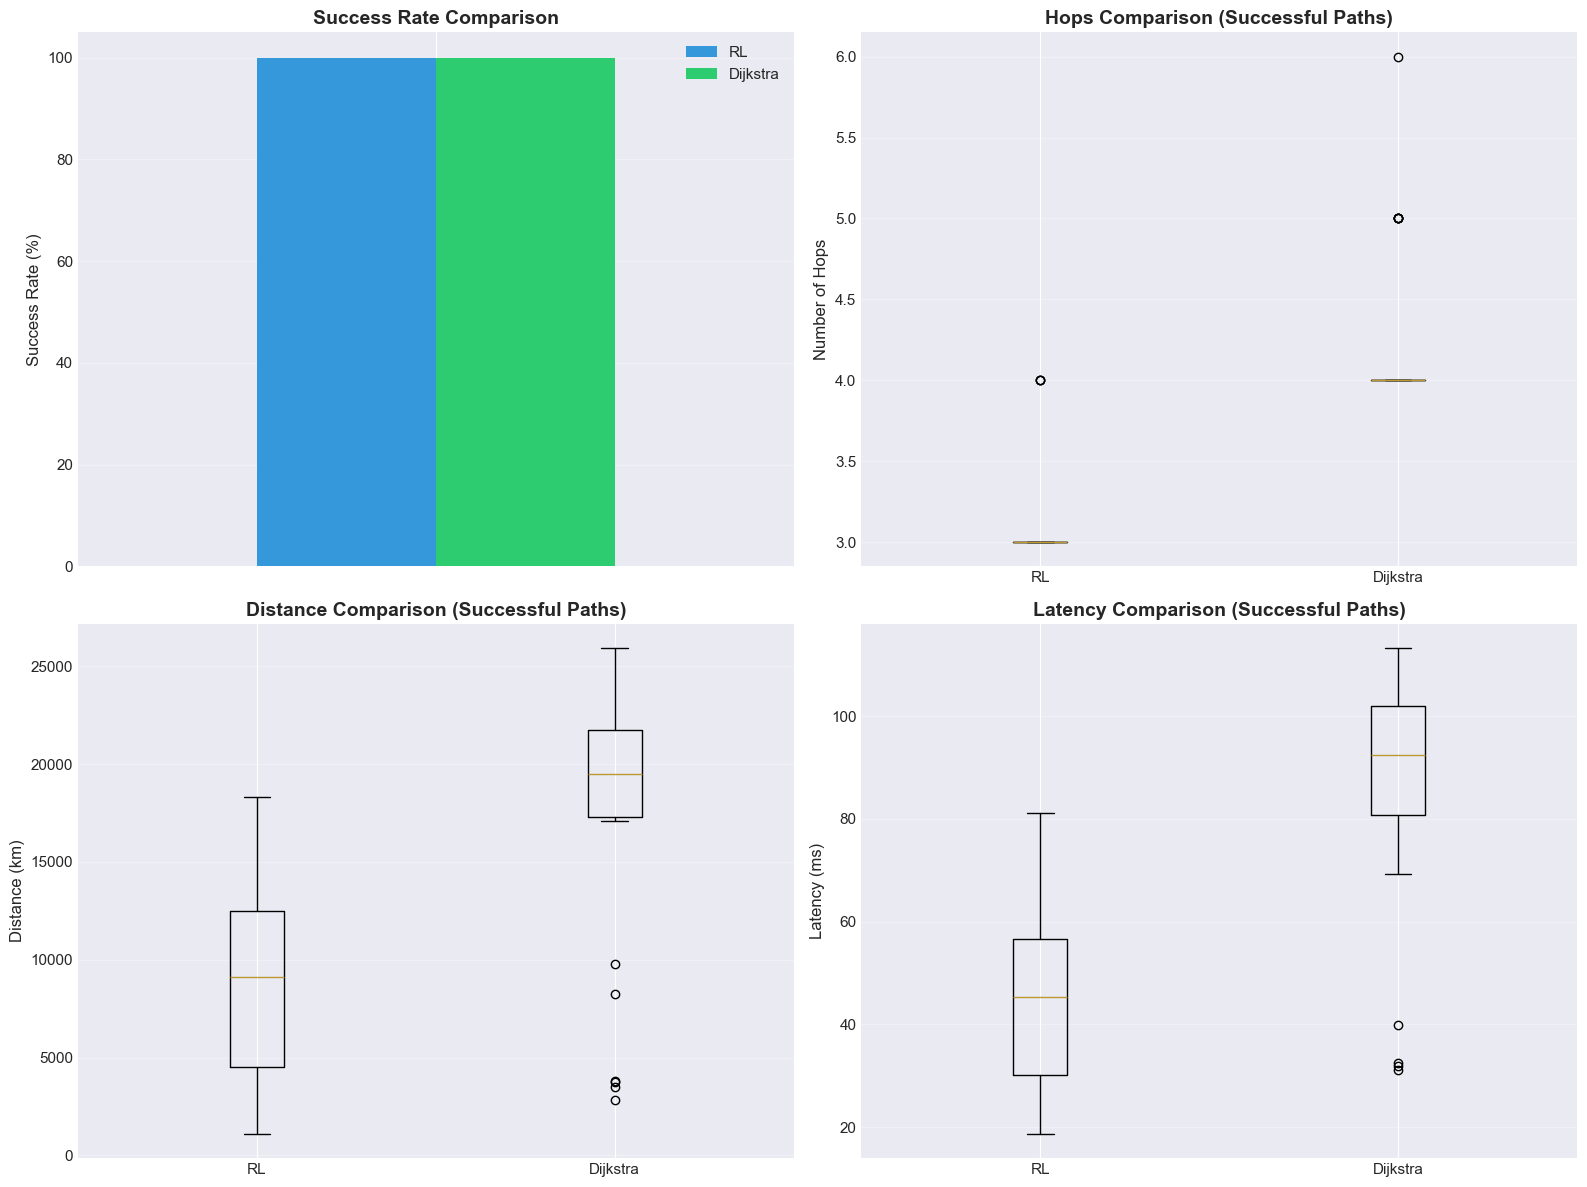

✓ Visualizations complete


In [8]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Success Rate Comparison
ax1 = axes[0, 0]
success_data = {
    'RL': [rl_success_rate],
    'Dijkstra': [dijkstra_success_rate]
}
df_success = pd.DataFrame(success_data)
df_success.plot(kind='bar', ax=ax1, color=['#3498db', '#2ecc71'])
ax1.set_ylabel('Success Rate (%)', fontsize=12)
ax1.set_title('Success Rate Comparison', fontsize=14, fontweight='bold')
ax1.set_xticklabels([''], rotation=0)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 105])

# 2. Hops Comparison (for successful paths)
ax2 = axes[0, 1]
if len(both_successful) > 0:
    hops_data = {
        'RL': both_successful['rl_hops'].values,
        'Dijkstra': both_successful['dijkstra_hops'].values
    }
    ax2.boxplot([hops_data['RL'], hops_data['Dijkstra']], labels=['RL', 'Dijkstra'])
    ax2.set_ylabel('Number of Hops', fontsize=12)
    ax2.set_title('Hops Comparison (Successful Paths)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
else:
    ax2.text(0.5, 0.5, 'No successful paths\nfor comparison', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Hops Comparison', fontsize=14, fontweight='bold')

# 3. Distance Comparison
ax3 = axes[1, 0]
if len(both_successful) > 0:
    distance_data = {
        'RL': both_successful['rl_distance_km'].values,
        'Dijkstra': both_successful['dijkstra_distance_km'].values
    }
    ax3.boxplot([distance_data['RL'], distance_data['Dijkstra']], labels=['RL', 'Dijkstra'])
    ax3.set_ylabel('Distance (km)', fontsize=12)
    ax3.set_title('Distance Comparison (Successful Paths)', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
else:
    ax3.text(0.5, 0.5, 'No successful paths\nfor comparison', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Distance Comparison', fontsize=14, fontweight='bold')

# 4. Latency Comparison
ax4 = axes[1, 1]
if len(both_successful) > 0:
    latency_data = {
        'RL': both_successful['rl_latency_ms'].values,
        'Dijkstra': both_successful['dijkstra_latency_ms'].values
    }
    ax4.boxplot([latency_data['RL'], latency_data['Dijkstra']], labels=['RL', 'Dijkstra'])
    ax4.set_ylabel('Latency (ms)', fontsize=12)
    ax4.set_title('Latency Comparison (Successful Paths)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
else:
    ax4.text(0.5, 0.5, 'No successful paths\nfor comparison', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Latency Comparison', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")


In [9]:
# Show detailed path for a successful example
successful_examples = df[df['rl_success'] == True]

if len(successful_examples) > 0:
    example = successful_examples.iloc[0]
    
    print("=" * 60)
    print(f"Detailed Path Analysis: {example['source_gs_id']} → {example['dest_gs_id']}")
    print("=" * 60)
    
    print(f"\n📍 Direct Distance: {example['gs_distance_km']:.2f} km")
    
    if example['rl_path'] and example['rl_path'].get('path'):
        print(f"\n🤖 RL Path ({example['rl_hops']} hops, {example['rl_distance_km']:.2f}km, {example['rl_latency_ms']:.2f}ms):")
        for i, segment in enumerate(example['rl_path']['path']):
            seg_type = segment.get('type', 'unknown')
            seg_id = segment.get('id', 'unknown')
            print(f"  {i+1}. [{seg_type.upper()}] {seg_id}")
    
    if example['dijkstra_path'] and example['dijkstra_path'].get('path'):
        print(f"\n📐 Dijkstra Path ({example['dijkstra_hops']} hops, {example['dijkstra_distance_km']:.2f}km, {example['dijkstra_latency_ms']:.2f}ms):")
        for i, segment in enumerate(example['dijkstra_path']['path']):
            seg_type = segment.get('type', 'unknown')
            seg_id = segment.get('id', 'unknown')
            print(f"  {i+1}. [{seg_type.upper()}] {seg_id}")
else:
    print("No successful RL paths to analyze")


Detailed Path Analysis: GS-042 → GS-036

📍 Direct Distance: 9155.83 km

🤖 RL Path (3 hops, 9155.83km, 45.54ms):
  1. [TERMINAL] DUMMY-SRC-GS-042
  2. [NODE] GS-042
  3. [NODE] GS-036
  4. [TERMINAL] DUMMY-DEST-GS-036

📐 Dijkstra Path (4 hops, 18595.93km, 93.93ms):
  1. [TERMINAL] DUMMY-SRC-GS-042
  2. [NODE] GS-042
  3. [NODE] MEO-026
  4. [NODE] GS-036
  5. [TERMINAL] DUMMY-DEST-GS-036


## 9. Summary


In [10]:
print("=" * 60)
print("GS-to-GS Routing Test Summary")
print("=" * 60)
print(f"\n✅ Test completed: {len(results)} GS pairs tested")
print(f"\n📊 Key Findings:")
print(f"  1. RL Success Rate: {rl_success_rate:.1f}%")
print(f"  2. Dijkstra Success Rate: {dijkstra_success_rate:.1f}%")

if len(successful_rl) > 0:
    print(f"\n  3. RL Average Performance:")
    print(f"     - Hops: {successful_rl['rl_hops'].mean():.2f}")
    print(f"     - Distance: {successful_rl['rl_distance_km'].mean():.2f} km")
    print(f"     - Latency: {successful_rl['rl_latency_ms'].mean():.2f} ms")

if len(both_successful) > 0:
    print(f"\n  4. Comparison (when both succeed):")
    avg_rl_hops = both_successful['rl_hops'].mean()
    avg_dijkstra_hops = both_successful['dijkstra_hops'].mean()
    print(f"     - RL avg hops: {avg_rl_hops:.2f} vs Dijkstra: {avg_dijkstra_hops:.2f}")
    
    if avg_rl_hops < avg_dijkstra_hops:
        print(f"     ✅ RL finds shorter paths (fewer hops)")
    elif avg_rl_hops > avg_dijkstra_hops:
        print(f"     ⚠️  Dijkstra finds shorter paths")
    else:
        print(f"     ➖ Similar hop count")

print(f"\n💡 Conclusion:")
if rl_success_rate >= 80:
    print(f"  ✅ Model successfully learns GS-to-GS routing")
elif rl_success_rate >= 50:
    print(f"  ⚠️  Model shows moderate performance, may need more training")
else:
    print(f"  ❌ Model needs significant improvement or retraining")

print("\n" + "=" * 60)


GS-to-GS Routing Test Summary

✅ Test completed: 30 GS pairs tested

📊 Key Findings:
  1. RL Success Rate: 100.0%
  2. Dijkstra Success Rate: 100.0%

  3. RL Average Performance:
     - Hops: 3.10
     - Distance: 8818.62 km
     - Latency: 44.92 ms

  4. Comparison (when both succeed):
     - RL avg hops: 3.10 vs Dijkstra: 4.23
     ✅ RL finds shorter paths (fewer hops)

💡 Conclusion:
  ✅ Model successfully learns GS-to-GS routing

